<a href="https://colab.research.google.com/github/YolandaMDavis/wildtrack-iqa/blob/task-amenability/task_amenability_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym==0.17.3
!pip install stable-baselines==2.10.2
!pip install h5py==3.0.0
!pip install tensorflow==1.13.1
!pip install tensorboard==1.13.1
!pip install Keras==2.2.4
!pip install Keras-Applications==1.0.8
!pip install Keras-Preprocessing==1.1.2
!pip install keras-rl==0.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 30.3 MB/s 
     |████████████████████████████████| 1.0 MB 59.6 MB/s 
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654653 sha256=16fb4cc9917ac5dbb03d674151bcbf6a727a49830934640a724791aa6de84683
  Stored in directory: /root/.cache/pip/wheels/d1/81/4b/dd9c029691022cb957398d1f015e66b75e37637dda61abdf58
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 35.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 32.9 MB/s 
  Attempting uninstall: h5py
    Found existing ins

In [2]:
#Only needed to copy data to local drive can be skipped if zip file is already available in working folder
import shutil

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy and extract tar file
shutil.copy(PARENT_DIR + '/data/Cropped_WildTrack.zip', 'Cropped_WildTrack.zip')

# get downstream task model
shutil.copy(PARENT_DIR + '/task-amenability/species/model.pt', 'species_model.pt')

shutil.copy(PARENT_DIR + '/task-amenability/object/model.pt', 'object_model.pt')


Mounted at /content/drive


'object_model.pt'

In [3]:
# clone the repository and move data file
!git clone https://github.com/YolandaMDavis/wildtrack-iqa.git
!mv Cropped_WildTrack.zip wildtrack-iqa/.
!mv species_model.pt wildtrack-iqa/.
!mv object_model.pt wildtrack-iqa/.
%cd "wildtrack-iqa"
!git checkout task-amenability
!mv species_model.pt taskamenability/taskpredictor/species/model.pt
!mv object_model.pt taskamenability/taskpredictor/objdet/model.pt


Cloning into 'wildtrack-iqa'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 108 (delta 41), reused 70 (delta 17), pack-reused 0
Receiving objects: 100% (108/108), 518.61 KiB | 17.29 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/wildtrack-iqa
Branch 'task-amenability' set up to track remote branch 'task-amenability' from 'origin'.
Switched to a new branch 'task-amenability'


In [4]:
from zipfile import ZipFile
# extract zip file
with ZipFile('Cropped_WildTrack.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [5]:
#%cd "wildtrack-iqa"

import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import albumentations as A

with open('taskamenability/taskpredictor/species/class_mapping.json') as data:
    mappings = json.load(data)

class_mapping = {item['model_idx']: item['class_name'] for item in mappings}
device = torch.device('cpu')
model = torch.jit.load('taskamenability/taskpredictor/species/model.pt').to(device)
transforms = A.load('taskamenability/taskpredictor/species/transforms.json')

In [6]:
from torch.utils import data
import csv
import random
import torch
import yaml
import cv2
import os

from time import process_time
from torch.utils.data import Dataset

root_dir = '/content/wildtrack-iqa'
data_dir = root_dir + '/RAW'

def get_key(val, item_dict):
    for key, value in item_dict.items():
        if val == value:
            return key
    return -1

def createImageSamples(img_shape, num_samples):
  x = np.random.rand(num_samples, img_shape[0], img_shape[1], img_shape[2])
  y = np.random.randint(low=0, high=2, size=(num_samples, 1))
  return (x,y)

def generate_data_sets(sample_percentage=1):

    image_reference_list = []
    subdirectories = list(os.walk(data_dir, topdown=False))[:-1]

    for subdir in subdirectories:
        image_location = subdir[0]
        images = subdir[2]
        species_rating = image_location.rsplit('/', 1)[-1].replace('_', ' ')
        subjective_score = int(species_rating.rsplit(' ', 1)[-1])
        species_class = species_rating.rsplit(' ', 1)[:-1][0]
        if len(species_class.rsplit(' ', 1)) > 1:
            species = species_class.rsplit(' ')[0]
            animal_class = ' '.join(species_class.rsplit(' ')[1:])
        else:
            animal_class = 'Unknown'
            species = species_class

        for image in images:
            class_name = species if animal_class == 'Unknown' else species + ': ' + animal_class
            class_index = get_key(class_name, class_mapping)
            if class_index > -1:
              image_reference = (image_location, species, animal_class, image, class_index, subjective_score)
              image_reference_list.append(image_reference)
    
    # add percentage of generated data
    #samples = int(len(image_reference_list) * .20)
    #for i in range(0,samples):
    #  image_reference_list.append(('sample','sample','sample','sample',0))

    # shuffle then split
    seed = 1234
    random.Random(seed).shuffle(image_reference_list)

    train_index = int(len(image_reference_list) * 0.6 * sample_percentage)
    test_index = -int(len(image_reference_list) * 0.2 * sample_percentage) 
    val_index = test_index * 2

    training = image_reference_list[:train_index]
    validation = image_reference_list[val_index:test_index]
    testing = image_reference_list[test_index:]
    return training, validation, testing

def convert_image(img_test):
    image = Image.open(img_test)
    #convert bw to RGB
    bands = image.getbands()
    if len(bands) == 1:
      image = image.convert(mode='RGB')
    image = np.array(image)
    image = transforms(image=image)['image']
    x = torch.from_numpy(image).to(device)
    return x


def transform_images(images):
  x = []
  y = []
  for img in images:
      image_name = img[0]+'/'+img[3]
      image = convert_image(image_name)
      x.append(image)
      y.append(img[4])

  return np.array(x), np.array(y)


In [35]:
# take a percentage of the full data set as a training/test/validation sample
sample_size=1
train, valid, test = generate_data_sets(sample_size)
x_train, y_train = transform_images(train)
x_val, y_val = transform_images(valid)
x_test, y_test = transform_images(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


**Execute the below installation only in Colab environment**

In [36]:
from taskamenability.interface import PPOInterface

img_shape = (512,512,3)
task_predictor = model
interface = PPOInterface(x_train, y_train, x_val, y_val, x_test, y_test, task_predictor, img_shape)

In [37]:
interface.train(10)

Training started for 10 episodes:
Reward: 0.3333333429497497
-----------------------------------
| approxkl           | 0.20984882 |
| clipfrac           | 0.576579   |
| explained_variance | -36.5      |
| fps                | 2          |
| n_updates          | 1          |
| policy_entropy     | 1.4189528  |
| policy_loss        | 0.09573734 |
| serial_timesteps   | 950        |
| time_elapsed       | 1.6e-05    |
| total_timesteps    | 950        |
| value_loss         | 7270.8257  |
-----------------------------------
Reward: 0.30000005134368835
-------------------------------------
| approxkl           | 0.0020138524 |
| clipfrac           | 0.018157896  |
| explained_variance | -23.9        |
| fps                | 2            |
| n_updates          | 2            |
| policy_entropy     | 1.4189728    |
| policy_loss        | 0.003717964  |
| serial_timesteps   | 1900         |
| time_elapsed       | 412          |
| total_timesteps    | 1900         |
| value_loss         | 40

In [38]:
preds = []
class_preds = []
for item in interface.x_holdout:
  obs = item.permute(2, 0, 1).unsqueeze(dim=0).float()
  y_pred = model(obs)
  y_pred = y_pred.argmax(dim=1).squeeze().item()
  class_preds.append(y_pred)
  preds.append(interface.model.predict(item))

In [39]:
# percentage where quality assessment matched the actual outcome (i.e. if deemed 1 it could truly be classified, if deemed 0 it could not be classified)
class_actuals = [ item[4] for item in test]
subjective_quality = [ item[5] for item in test]

accurate_quality_assessment = []
for i in range(len(class_preds)):
  pred_value = preds[i][0][0]
  if class_preds[i] == class_actuals[i] and pred_value >= 0.5:
    accurate_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and pred_value < 0.5:
    accurate_quality_assessment.append(1)
  else:
    accurate_quality_assessment.append(0)

overall_percentage_correct = np.mean(np.array(accurate_quality_assessment)) * 100
overall_percentage_correct


32.48407643312102

In [40]:
# how well does subjective scores do in predicting what images should be used vs not used?
subjective_quality_assessment = []

for i in range(len(class_preds)):
  if class_preds[i] == class_actuals[i] and subjective_quality[i] >= 4:
    subjective_quality_assessment.append(1)
  if class_preds[i] != class_actuals[i] and subjective_quality[i] < 4:
    subjective_quality_assessment.append(1)
  else:
    subjective_quality_assessment.append(0)

subjective_percentage_correct = np.mean(np.array(subjective_quality_assessment)) * 100
subjective_percentage_correct

35.264663805436335

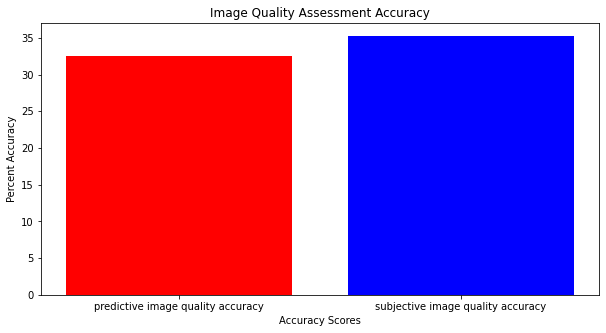

In [41]:
# creating the dataset
data = {'predictive image quality accuracy':overall_percentage_correct, 'subjective image quality accuracy': subjective_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Image Quality Assessment Accuracy")
plt.show()

In [42]:
# how well are we doing when predicting classes that truly matched?

matching_quality_assessment = []
for i in range(len(class_preds)):
  pred_value = preds[i][0][0]
  if class_preds[i] == class_actuals[i] and pred_value >= 0.5:
    matching_quality_assessment.append(1)
  elif class_preds[i] == class_actuals[i] and pred_value < 0.5:
    matching_quality_assessment.append(0)
  else:
    matching_quality_assessment.append(-1)

matching_percentage_correct = np.mean(np.array([value for value in matching_quality_assessment if (value == 0 or value == 1) ])) * 100
matching_percentage_correct


24.405506883604506

In [43]:
# how well are we doing when predicting when not to use an image ?
non_matching_quality_assessment = []

for i in range(len(class_preds)):
  pred_value = preds[i][0][0]
  if class_preds[i] != class_actuals[i] and pred_value < .5:
    non_matching_quality_assessment.append(1)
  if class_preds[i] != class_actuals[i] and pred_value >= .5:
    non_matching_quality_assessment.append(0)
  else:
    non_matching_quality_assessment.append(-1)

non_matching_percentage_correct = np.mean(np.array([value for value in non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
non_matching_percentage_correct

77.62237762237763

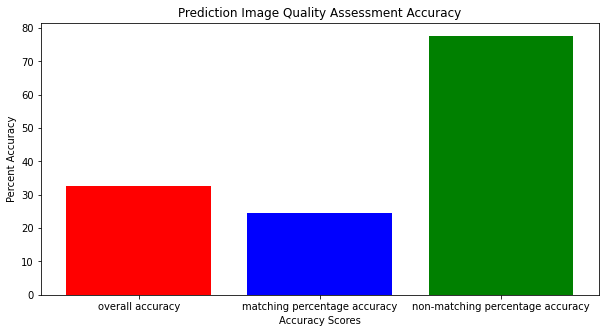

In [44]:
# creating the dataset
data = {'overall accuracy':overall_percentage_correct, 'matching percentage accuracy':matching_percentage_correct, 'non-matching percentage accuracy':non_matching_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue','green'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Prediction Image Quality Assessment Accuracy")
plt.show()

In [45]:
# how well are we doing when predicting classes that truly matched?

subj_matching_quality_assessment = []

for i in range(len(class_preds)):
  if class_preds[i] == class_actuals[i] and subjective_quality[i] >= 4:
    subj_matching_quality_assessment.append(1)
  elif class_preds[i] == class_actuals[i] and subjective_quality[i] < 4:
    subj_matching_quality_assessment.append(0)
  else:
    subj_matching_quality_assessment.append(-1)

subj_matching_percentage_correct = np.mean(np.array([value for value in subj_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_matching_percentage_correct

57.07133917396746

In [46]:
# how well are we doing when predicting when not to use an image ?
subj_non_matching_quality_assessment = []

for i in range(len(class_preds)):

  if class_preds[i] != class_actuals[i] and subjective_quality[i] < 4:
    subj_non_matching_quality_assessment.append(1)
  if class_preds[i] != class_actuals[i] and subjective_quality[i] >= 4:
    subj_non_matching_quality_assessment.append(0)
  else:
    subj_non_matching_quality_assessment.append(-1)

subj_non_matching_percentage_correct = np.mean(np.array([value for value in subj_non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_non_matching_percentage_correct

25.874125874125873

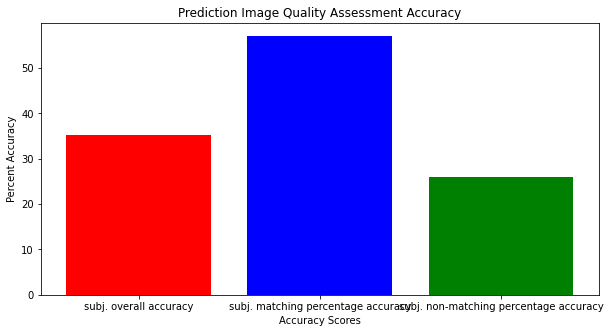

In [47]:
# creating the dataset
data = {'subj. overall accuracy':subjective_percentage_correct, 'subj. matching percentage accuracy': subj_matching_percentage_correct, 'subj. non-matching percentage accuracy': subj_non_matching_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue','green'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Prediction Image Quality Assessment Accuracy")
plt.show()

It looks like subjective scores only perform at 57% for truly high quality images, however when it says it's a poor image it doesn't do well.  Let's look at that a bit more...

In [48]:
# how many were classiable but considered poor quality?
subj_non_matching_quality_assessment = []

for i in range(len(class_preds)):

  if class_preds[i] == class_actuals[i] and subjective_quality[i] < 4:
    subj_non_matching_quality_assessment.append(1)
  if class_preds[i] == class_actuals[i] and subjective_quality[i] >= 4:
    subj_non_matching_quality_assessment.append(0)
  else:
    subj_non_matching_quality_assessment.append(-1)

subj_non_matching_percentage_incorrect = np.mean(np.array([value for value in subj_non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_non_matching_percentage_incorrect

42.92866082603254

In [49]:
# how many images were considered high quality but not classifiable?

subj_non_matching_quality_assessment = []

for i in range(len(class_preds)):

  if class_preds[i] != class_actuals[i] and subjective_quality[i] >= 4:
    subj_non_matching_quality_assessment.append(1)
  if class_preds[i] != class_actuals[i] and subjective_quality[i] < 4:
    subj_non_matching_quality_assessment.append(0)
  else:
    subj_non_matching_quality_assessment.append(-1)

subj_non_matching_percentage_incorrect = np.mean(np.array([value for value in subj_non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_non_matching_percentage_incorrect

74.12587412587412

Nearly 16% of images that were classifiable were considered poor quality. 89% of images that were considered high quality were not classifiable

Now let's compare this with the predicted quality assessment


In [50]:
# how many were classiable but considered poor quality?
pred_non_matching_quality_assessment = []

for i in range(len(class_preds)):
  pred_value = preds[i][0][0]
  if class_preds[i] == class_actuals[i] and pred_value < .5:
    pred_non_matching_quality_assessment.append(1)
  if class_preds[i] == class_actuals[i] and pred_value >= .5:
    pred_non_matching_quality_assessment.append(0)
  else:
    pred_non_matching_quality_assessment.append(-1)

pred_non_matching_percentage_incorrect = np.mean(np.array([value for value in pred_non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
pred_non_matching_percentage_incorrect

75.59449311639548

In [51]:
# how many were not classiable but considered high quality?
pred_non_matching_quality_assessment = []

for i in range(len(class_preds)):
  pred_value = preds[i][0][0]
  if class_preds[i] != class_actuals[i] and pred_value >= .5:
    pred_non_matching_quality_assessment.append(1)
  if class_preds[i] != class_actuals[i] and pred_value < .5:
    pred_non_matching_quality_assessment.append(0)
  else:
    pred_non_matching_quality_assessment.append(-1)

pred_non_matching_percentage_incorrect = np.mean(np.array([value for value in pred_non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
pred_non_matching_percentage_incorrect

22.377622377622377

(array([137., 560.,  24., 104.,  51., 134.,  44.,  29.,  51., 279.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

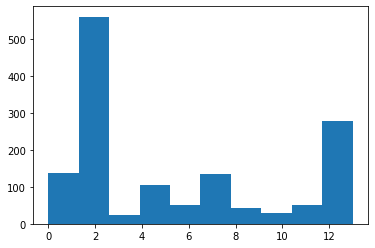

In [34]:
# figure out data distributiong

test_class_distribution = np.array([item[4] for item in train])

plt.hist(test_class_distribution)